In [1]:
import torch 
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import requests
from pathlib import Path

import torchmetrics
from timeit import default_timer as timer
from tqdm import tqdm

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**What are 3 areas in industry where computer vision is currently being used?**

1. Automated vehicles
2. Medical field
3. Manufacturing

**What is overfitting in machine learning?**

Overfitting is when the model is no longer detecting generalized patterns but memorizing an entire image's makeup. Which means that it will not recognize anything else but that exact image due to it having memorized the pattern of the entire image.

**Ways to prevent overfitting in machine learning**

1. Data augmentation - changing around the data such as rotation, scaling, and flipping. This helps in expanding the size of a dataset, especially when it's a small one.

2. Simplyfing a neural network - Remember that neurons mean more patterns to learn. If we reduce the number of neurons means that we lessen it's chance of 'memorizing' because it has less capacity to memorize. Too many neurons means a high variance meaning that it is more likely to learn the 'noise' of the training data. When we talk about noise that means the unecessary 'patterns' of the image.

3. Just get more data - the more data that you have means the less chances of you overfitting. This is the same as data augmentation but rather than changing by flipping, rotating, and scaling existing data - you just find more of them.

In [3]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
image.shape

torch.Size([1, 28, 28])

In [6]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [7]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Image Shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '5')

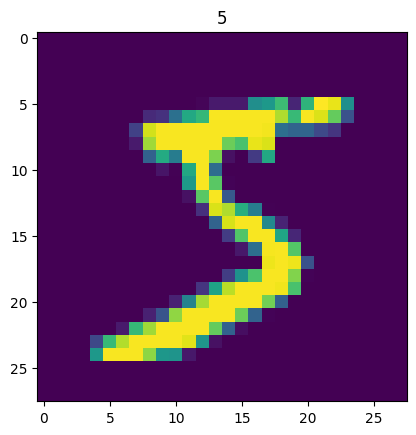

In [8]:
image, label = train_data[0]
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)

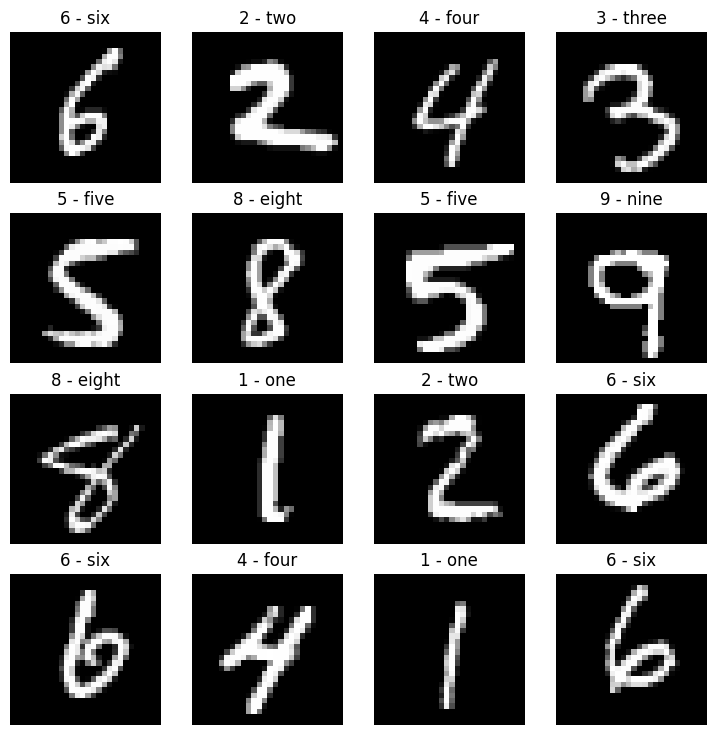

In [9]:
torch.manual_seed(14)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1): # accounting for zero-indexing
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [10]:
BATCH_SIZE = 32

train_dataloader = DataLoader (
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dataloader = DataLoader (
    test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of Train Dataloader: {len(train_dataloader)} Batchsize of {BATCH_SIZE}")
print(f"Length of Test Dataloader: {len(test_dataloader)} Batchsize of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000236C8D6FBC0>, <torch.utils.data.dataloader.DataLoader object at 0x00000236C9043860>)
Length of Train Dataloader: 1875 Batchsize of 32
Length of Test Dataloader: 313 Batchsize of 32


In [11]:
# train_dataloader is not iterable so we make it into one and then call next
# which brings the first batch of data
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [12]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device):

    train_loss, train_acc = 0,0
    model.to(device)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        
        train_preds = model(X)
        loss = loss_fn(train_preds, y)
        acc = accuracy_fn(y, train_preds.argmax(dim=1))

        train_loss += loss
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.5f}")

In [13]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device):

    test_loss, test_acc = 0,0
    model.to(device)
    model.train()

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)

            test_preds = model(X)
            loss = loss_fn(test_preds, y)
            acc = accuracy_fn(y, test_preds.argmax(dim=1))

            test_loss += loss
            test_acc += acc

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Train Loss: {test_loss:.5f} | Train Accuracy: {test_acc:.5f}")

In [14]:
class MNISTModelBaseline(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # Turning H , W (28x28) into HxW (728)
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape), 
        )

    def forward(self, x):
        return self.layer_stack(x)

In [15]:
torch.manual_seed(14)
baseline_model = MNISTModelBaseline(784, 10, len(class_names))
baseline_model.to(device)

MNISTModelBaseline(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(baseline_model.parameters(), lr=0.1)

In [17]:
train_time_start_on_gpu = timer()
epochs = 3 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_step(baseline_model, train_dataloader, loss_fn, optim, accuracy_fn, device)
    test_step(baseline_model, test_dataloader, loss_fn, accuracy_fn, device)

train_time_end_on_gpu = timer()
total_time = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Total Time: {total_time:.2f} Seconds")

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 0.40034 | Train Accuracy: 0.88723


 33%|████████████████████████████                                                        | 1/3 [00:18<00:36, 18.17s/it]

Train Loss: 0.31217 | Train Accuracy: 0.90665
Epoch: 1
--------
Train Loss: 0.30753 | Train Accuracy: 0.91345


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:37<00:18, 18.80s/it]

Train Loss: 0.29559 | Train Accuracy: 0.91723
Epoch: 2
--------
Train Loss: 0.29594 | Train Accuracy: 0.91692


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:55<00:00, 18.63s/it]

Train Loss: 0.28055 | Train Accuracy: 0.92392
Total Time: 55.88 Seconds


In [18]:
def make_preds(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    total_preds = []
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(dataloader, desc="Making Predictions"):
            X,y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.softmax(logits, dim=1).argmax(dim=1)
            total_preds.append(preds.cpu())

    return torch.cat(total_preds)

In [19]:
preds_tensor = make_preds(baseline_model, test_dataloader)

Making Predictions: 100%|███████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 207.92it/s]


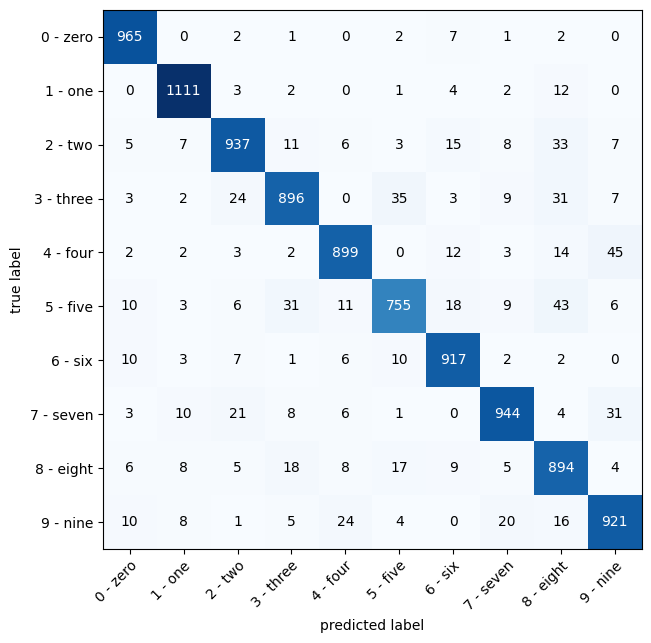

In [20]:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds = preds_tensor, target = test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), # We convert the tensor to NumPy arrays since Matplotlib
    class_names = class_names,
    figsize = (10,7)
)

**8 - GPU-Deviced CNN Model**

In [21]:
class MNISTModelConvolution(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3),
            nn.ReLU()
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3),
            nn.ReLU()
        )
        self.block_4 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*4*4, output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.classifier(x)
        return x 

In [22]:
cnn_model = MNISTModelConvolution(1, 10, 10)
cnn_model.to(device)

MNISTModelConvolution(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (block_4): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=10, bias=True)
  )
)

In [23]:
accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(cnn_model.parameters(), lr=0.1)

In [24]:
train_time_start_on_gpu = timer()
epochs = 3 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_step(cnn_model, train_dataloader, loss_fn, optim, accuracy_fn, device)
    test_step(cnn_model, test_dataloader, loss_fn, accuracy_fn, device)

train_time_end_on_gpu = timer()
total_time = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Total Time: {total_time:2f} Seconds")

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 0.33870 | Train Accuracy: 0.88642


 33%|████████████████████████████                                                        | 1/3 [00:24<00:48, 24.16s/it]

Train Loss: 0.08414 | Train Accuracy: 0.97524
Epoch: 1
--------
Train Loss: 0.09001 | Train Accuracy: 0.97197


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:47<00:23, 23.56s/it]

Train Loss: 0.07697 | Train Accuracy: 0.97564
Epoch: 2
--------
Train Loss: 0.07128 | Train Accuracy: 0.97765


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:10<00:00, 23.50s/it]

Train Loss: 0.05968 | Train Accuracy: 0.97993
Total Time: 70.514894 Seconds


In [25]:
preds_tensor = make_preds(cnn_model, test_dataloader)

Making Predictions: 100%|███████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 160.08it/s]


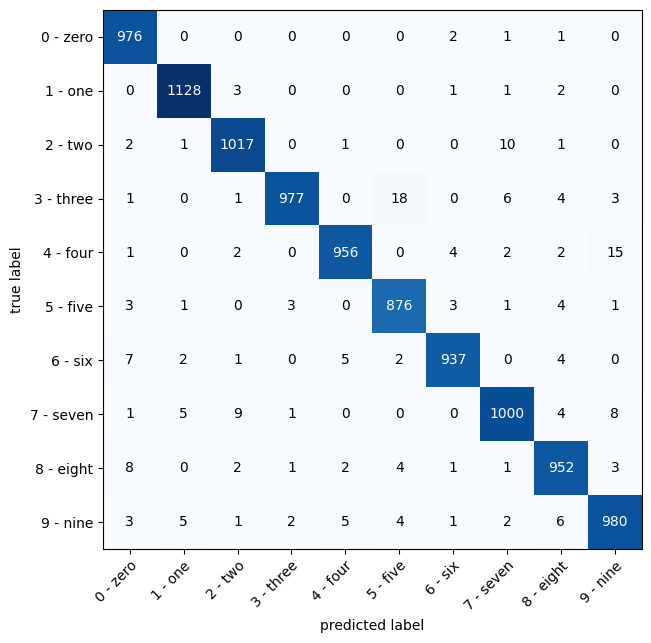

In [26]:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds = preds_tensor, target = test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), # We convert the tensor to NumPy arrays since Matplotlib
    class_names = class_names,
    figsize = (10,7)
)

**9: CPU-Deviced CNN Model**

In [27]:
device = 'cpu'
cnn_model_cpu = MNISTModelConvolution(1, 10, 10)
cnn_model_cpu.to(device)

accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(cnn_model_cpu.parameters(), lr=0.1)

train_time_start_on_cpu = timer()
epochs = 3 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_step(cnn_model, train_dataloader, loss_fn, optim, accuracy_fn, device)
    test_step(cnn_model, test_dataloader, loss_fn, accuracy_fn, device)

train_time_end_on_cpu = timer()
total_time = train_time_end_on_cpu - train_time_start_on_cpu
print(f"Total Time: {total_time:2f} Seconds")

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 0.05739 | Train Accuracy: 0.98182


 33%|████████████████████████████                                                        | 1/3 [00:41<01:23, 41.79s/it]

Train Loss: 0.05968 | Train Accuracy: 0.97993
Epoch: 1
--------
Train Loss: 0.05739 | Train Accuracy: 0.98182


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:27<00:44, 44.13s/it]

Train Loss: 0.05968 | Train Accuracy: 0.97993
Epoch: 2
--------
Train Loss: 0.05739 | Train Accuracy: 0.98182


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:04<00:00, 41.52s/it]

Train Loss: 0.05968 | Train Accuracy: 0.97993
Total Time: 124.558728 Seconds


**10: Visualizing Predictions**

In [196]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [38]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test Sample Image Shape: {test_samples[0].shape}\n Test Sample Image Label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test Sample Image Shape: torch.Size([1, 28, 28])
 Test Sample Image Label: 2 (2 - two)


In [49]:
pred_probs = []
cnn_model.eval()
with torch.inference_mode():
    for sample in test_samples:
        sample = torch.unsqueeze(sample, dim=0).to(device)
        logits = cnn_model(sample)
        probs = torch.softmax(logits, dim=1)
        labels = probs.argmax(dim=1)
        pred_probs.append(labels.cpu())

pred_probs = torch.stack(pred_probs)

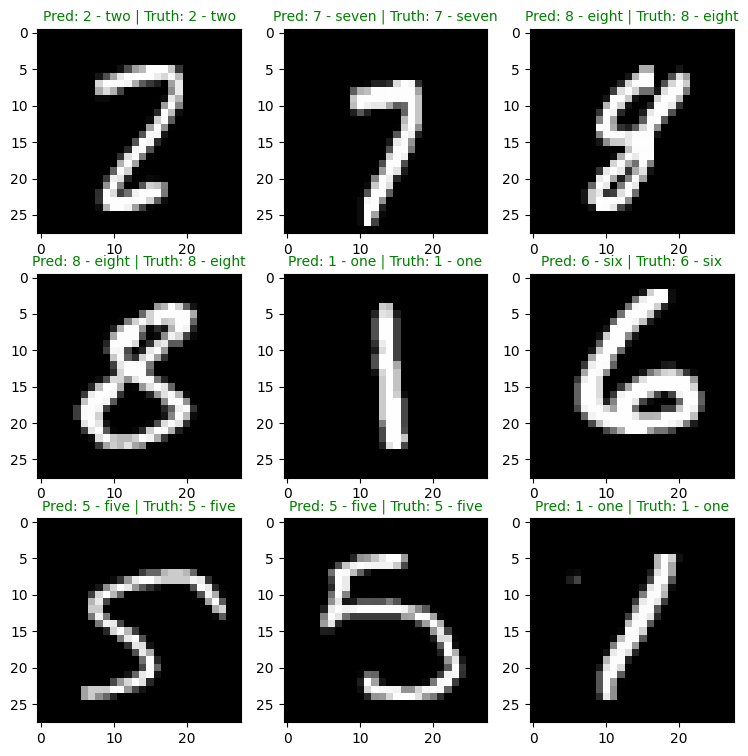

In [51]:
plt.figure(figsize=(9,9))
nrows, ncols = 3,3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_probs[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")

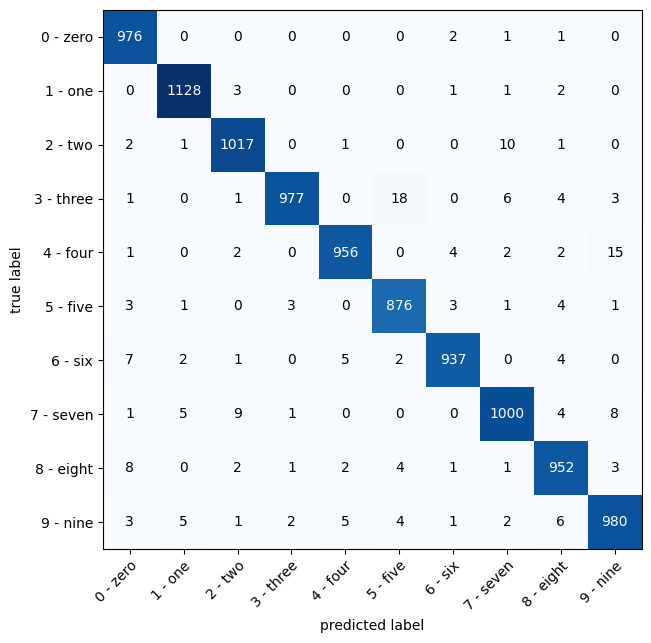

In [40]:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds = pred_classes, target = test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), # We convert the tensor to NumPy arrays since Matplotlib
    class_names = class_names,
    figsize = (10,7)
)

In [155]:
device = 'cuda'

In [157]:
x = torch.rand(1,3,64,64)
x.shape

torch.Size([1, 3, 64, 64])

In [158]:
conv_layer = nn.Conv2d(3, 4, 3)
conv_layer

Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))

In [159]:
y = conv_layer(x)
y.shape

torch.Size([1, 4, 62, 62])

In [168]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [169]:
class ExpFashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, 1 ,1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1 ,1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*7*7, output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [170]:
cnn_modelv1 = ExpFashionMNISTModel(1, 10, len(class_names))
cnn_modelv1

ExpFashionMNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [171]:
accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(cnn_modelv1.parameters(), lr=0.1)

In [253]:
trainFashion_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

testFashion_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [254]:
BATCH_SIZE = 32

trainFashion_dataloader = DataLoader (
    trainFashion_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

testFashion_dataloader = DataLoader (
    testFashion_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

print(f"Dataloaders: {trainFashion_dataloader, testFashion_dataloader}")
print(f"Length of Train Dataloader: {len(trainFashion_dataloader)} Batchsize of {BATCH_SIZE}")
print(f"Length of Test Dataloader: {len(testFashion_dataloader)} Batchsize of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000236EBDC3170>, <torch.utils.data.dataloader.DataLoader object at 0x00000236CB075250>)
Length of Train Dataloader: 1875 Batchsize of 32
Length of Test Dataloader: 313 Batchsize of 32


In [227]:
train_time_start_on_gpu = timer()
epochs = 3 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_step(cnn_modelv1, trainFashion_dataloader, loss_fn, optim, accuracy_fn, device)
    test_step(cnn_modelv1, testFashion_dataloader, loss_fn, accuracy_fn, device)

train_time_end_on_gpu = timer()
total_time = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Total Time: {total_time:2f} Seconds")

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 0.48324 | Train Accuracy: 0.82637


 33%|████████████████████████████                                                        | 1/3 [00:21<00:43, 21.62s/it]

Train Loss: 0.43209 | Train Accuracy: 0.84405
Epoch: 1
--------
Train Loss: 0.34123 | Train Accuracy: 0.87592


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:44<00:22, 22.53s/it]

Train Loss: 0.34742 | Train Accuracy: 0.87570
Epoch: 2
--------
Train Loss: 0.31050 | Train Accuracy: 0.88727


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:08<00:00, 22.86s/it]

Train Loss: 0.33383 | Train Accuracy: 0.87780
Total Time: 68.577046 Seconds


In [255]:
fashionPreds_tensor = make_preds(cnn_modelv1, testFashion_dataloader)
fashionPreds_tensor

Making Predictions: 100%|███████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 155.76it/s]


tensor([9, 2, 1,  ..., 8, 1, 5])

In [256]:
check_equality = fashionPreds_tensor != testFashion_data.targets

In [257]:
take_unequal = torch.nonzero(check)
converted = check2.tolist()
converted

[[18],
 [247],
 [290],
 [326],
 [359],
 [449],
 [582],
 [591],
 [629],
 [655],
 [659],
 [674],
 [684],
 [707],
 [740],
 [938],
 [947],
 [1014],
 [1039],
 [1112],
 [1118],
 [1178],
 [1182],
 [1226],
 [1242],
 [1247],
 [1260],
 [1299],
 [1319],
 [1414],
 [1441],
 [1527],
 [1530],
 [1549],
 [1621],
 [1709],
 [1754],
 [1782],
 [1850],
 [1878],
 [1901],
 [1955],
 [2004],
 [2018],
 [2035],
 [2043],
 [2107],
 [2118],
 [2129],
 [2130],
 [2135],
 [2182],
 [2266],
 [2272],
 [2280],
 [2293],
 [2309],
 [2369],
 [2387],
 [2454],
 [2488],
 [2597],
 [2654],
 [2720],
 [2742],
 [2780],
 [2860],
 [2896],
 [2921],
 [2927],
 [2970],
 [2975],
 [2990],
 [2995],
 [3030],
 [3060],
 [3073],
 [3100],
 [3157],
 [3206],
 [3289],
 [3503],
 [3511],
 [3520],
 [3559],
 [3626],
 [3662],
 [3751],
 [3762],
 [3782],
 [3808],
 [3818],
 [3846],
 [3906],
 [3941],
 [3951],
 [3985],
 [4075],
 [4078],
 [4176],
 [4207],
 [4224],
 [4238],
 [4256],
 [4497],
 [4500],
 [4505],
 [4536],
 [4567],
 [4639],
 [4671],
 [4740],
 [4807],
 

In [258]:
fashionPreds_tensor[247], testFashion_data.targets[247]

(tensor(2), tensor(4))

Image Shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '3')

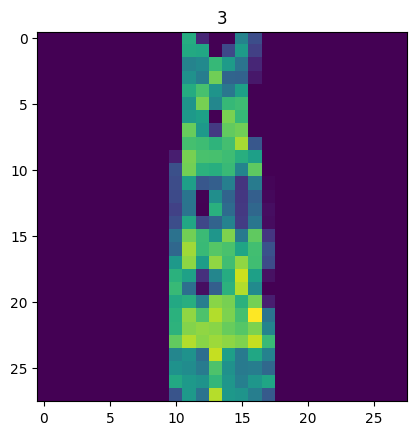

In [261]:
image, label = trainFashion_data[247] # Taking one sample from train data
print(f"Image Shape: {image.shape}") 
plt.imshow(image.squeeze()) # Image shape is [1, 28, 28]. 
# imshow needs only Height & Width so we need to do squeeze and remove the color channel
plt.title(label)

In [262]:
classFashion_names = trainFashion_data.classes
classFashion_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [290]:
image, label = trainFashion_data[0]
image.shape

torch.Size([1, 28, 28])

In [286]:
image, label = trainFashion_data[0]
squeezed = image.squeeze()
squeezed.shape

torch.Size([28, 28])

In [315]:
img, label = trainFashion_data[1]
img.shape, label

(torch.Size([1, 28, 28]), 0)

In [318]:
torch.manual_seed(42)
fig = plt.figure(figsize=(12,12))
rows, cols = 4, 4
for i in converted:
    img, label = trainFashion_data[i]
    fig.add_subplot(rows, cols, i)
    if img.ndimension() == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img[0], cmap="gray")  # If still 3D, select the first channel
    pred_label = classFashion_names[fashionPreds_tensor[i]]
    truth_label = classFashion_names[testFashion_data.targets[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")

ValueError: Too many dimensions: 3 > 2.

<Figure size 1200x1200 with 0 Axes>

In [293]:
plt.figure(figsize=(9,9))
nrows, ncols = 3,3
for i in converted:
    img, label = trainFashion_data[i]
    print('check')
    plt.subplot(nrows, ncols, 2)
    plt.imshow(img.squeeze(), cmap="gray")
    pred_label = classFashion_names[fashionPreds_tensor[i]]
    truth_label = classFashion_names[testFashion_data.targets[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")

ValueError: Too many dimensions: 3 > 2.

<Figure size 900x900 with 0 Axes>